In [2]:
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



In [172]:

def get_data():
    train = torchvision.datasets.FashionMNIST("data/train", train=True, download=True)
    test = torchvision.datasets.FashionMNIST("data/test", train=False, download=True)

    x_train = train.data.numpy()
    y_train = train.targets.numpy()

    x_test = test.data.numpy()
    y_test = test.targets.numpy()

    return train, x_train, y_train, test, x_test, y_test

(60000, 28, 28)


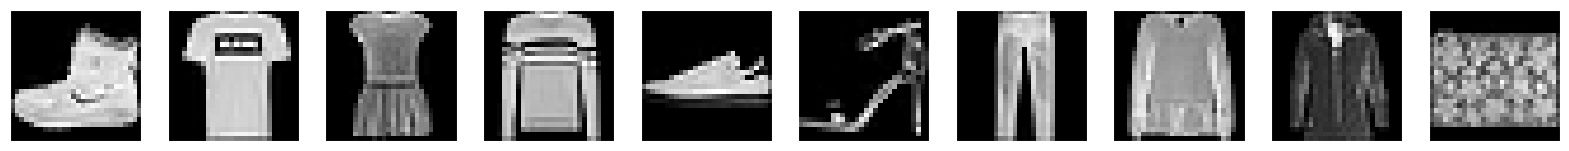

In [175]:

train_data, x_train, y_train, test_data, x_test, y_test = get_data()

n_class = 10
print(x_train.shape)
count = []
fig = plt.figure(figsize=(20, 5), facecolor='w')
for i in range(len(x_train)):
    if len(count) == n_class:
        break
    check = False
    for j in count:
        if j == y_train[i]:
            check = True
            break

    if check:
        continue

    ax = plt.subplot(1, n_class, len(count) + 1)
    xi, yi = train_data[i]
    plt.imshow(xi, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    count.append(yi)

plt.savefig('fashionMNIST_samples.png', bbox_inches='tight')
plt.show()

In [179]:

class Layer:
    def forward(self, x):
        pass

    def backward(self, error):
        pass

    def step(self, lr):
        pass

    def zero_grad(self):
        pass


class FCLayer(Layer):

    def __init__(self, in_size, out_size):
        self.y = None
        self.x = None
        self.weights = np.random.randn(in_size, out_size) / 100
        self.bias = np.random.randn(1, out_size) / 100
        self.bias_grad = 0
        self.weights_grad = np.zeros((in_size, out_size))

    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.weights) + self.bias
        return self.y

    def backward(self, error):
        self.bias_grad += error #+ self.bias
        self.weights_grad += np.dot(self.x.T, error) #+ self.weights
        return np.dot(error, self.weights.T)

    def zero_grad(self):
        self.bias_grad = 0
        self.weights_grad = np.zeros(self.weights_grad.shape)

    def step(self, lr):
        # print(self.bias_grad.min(), self.bias_grad.max(), self.weights_grad.min(), self.weights_grad.max(), self.bias.max(), self.weights.min())
        self.bias -= lr * self.bias_grad #/ self.bias_grad.max()
        self.weights -= lr * self.weights_grad #/ self.weights_grad.max()


class ActivationLayer(Layer):

    def __init__(self, f, f_d):
        self.y = None
        self.x = None
        self.f = f
        self.f_d = f_d

    def forward(self, x):
        self.x = x
        self.y = self.f(x)
        return self.y

    def backward(self, error):
        return  self.f_d(self.x, error)


def mse(y, y_pre):
    return np.dot((y - y_pre), (y - y_pre).T)

def mse_d(y, y_pre):
    return -2 * (y - y_pre)

def softmax(x):
    xt = x.copy()
    c = xt.max()
    xt = c + np.log(np.exp(xt-c).sum())
    return x - xt.reshape((-1, 1))

def softmax_d(x, error):
    # sf = softmax(x)
    # #
    # # print((sf * np.identity(sf.size) - sf.T @ sf))
    # # return error @ (sf * np.identity(sf.size) - sf.T @ sf)
    # sf = sf.reshape(-1,1)
    # return error @ (np.diagflat(sf) - np.dot(sf, sf.T))
    return (error - np.exp(softmax(x)) * error.sum())



def relu(x):
    return np.maximum(x, 0)

def relu_d(x, error):
    xd = np.ones(x.shape)
    xd[x < 0] = 0
    return xd * error
    # xd = np.ones(error.shape)
    # xd[error < 0] = 0
    # return xd

class NN:

    def __init__(self, input_size, output_size):
        self.loss = None
        self.loss_prime = None
        self.sequence = [
            FCLayer(input_size, 256),
            ActivationLayer(relu, relu_d),
            FCLayer(256, output_size),
            # ActivationLayer(relu, relu_d),
            # FCLayer(64, 64),
            # ActivationLayer(relu, relu_d),
            # FCLayer(64, 32),
            # ActivationLayer(relu, relu_d),
            # FCLayer(32, output_size),
            ActivationLayer(softmax, softmax_d)
        ]

    def set_loss(self, loss_fn, loss_fn_d):
        self.loss = loss_fn
        self.loss_prime = loss_fn_d

    def zero_grad(self):
        for f in self.sequence:
            f.zero_grad()

    def step(self, lr):
        for f in self.sequence:
            f.step(lr)

    def learn(self, x_train, y_train, epochs, batch, lr, x_test, y_test):
        train_res = []
        test_res = []
        for i in range(epochs):
            print('epoch ', i, ':')
            err = 0
            train_cnt = 0

            for j in range(0, len(y_train), batch):
                print('batch ', j // batch)
                xb = x_train[j:j + batch]
                yb = y_train[j:j + batch]
                self.zero_grad()
                for l in range(len(xb)):
                    yl = xb[l].reshape((1, len(xb[l])))
                    for f in self.sequence:
                        yl = f.forward(yl)
                    train_cnt += np.argmax(yl) == np.argmax(yb[l])
                    err += self.loss(yb[l], yl)
                    # print(err.shape)
                    back_err = self.loss_prime(yb[l], yl)
                    for f in reversed(self.sequence):
                        back_err = f.backward(back_err)
                        # print(back_err)

                self.step(lr)
            train_res.append(train_cnt / len(y_train))
            print('epoch %d/%d   train_error=%f  train_acc=%f' % (i+1, epochs, err / len(y_train), train_cnt / len(y_train)))


            test_cnt = 0
            err = 0

            for j in range(len(x_test)):
                yj = x_test[j]
                for f in self.sequence:
                    yj = f.forward(yj)
                test_cnt += np.argmax(yj) == np.argmax(y_test[j])
                err += self.loss(y_train[j], yj)
            test_res.append(test_cnt / len(y_test))
            print('epoch %d/%d   test_error=%f  test_acc=%f' % (i+1, epochs,
                                                                err / len(y_test),
                                                                test_cnt / len(y_test)))

        plt.plot(range(epochs), train_res)
        plt.plot(range(epochs), test_res)
        plt.show()

        test_cnt = 0
        for j in range(len(x_test)):
            yj = x_test[j]
            for f in self.sequence:
                yj = f.forward(yj)
            test_cnt += np.argmax(yj) == np.argmax(y_test[j])
        print('final test_acc=%f' % (test_cnt / len(y_test)))

    def predict(self, xi):
        yi = xi.copy()
        for f in self.sequence:
            yi = f.forward(yi)
        return np.argmax(yi)




In [177]:
x_train = x_train.reshape((-1, 28 * 28))
x_train = (x_train - x_train.mean()) / np.std(x_train)
yy_train = np.zeros((len(y_train), 10), np.float64)
yy_train[range(len(y_train)), y_train] = 1.0
y_train = yy_train

x_test = x_test.reshape((-1, 28 * 28))
x_test = (x_test - x_test.mean()) / np.std(x_test)
yy_test = np.zeros((len(y_test), 10), np.float64)
yy_test[range(len(y_test)), y_test] = 1.0
y_test = yy_test

epoch  0 :
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15
batch  16
batch  17
batch  18
batch  19
batch  20
batch  21
batch  22
batch  23
batch  24
batch  25
batch  26
batch  27
batch  28
batch  29
batch  30
batch  31
batch  32
batch  33
batch  34
batch  35
batch  36
batch  37
batch  38
batch  39
batch  40
batch  41
batch  42
batch  43
batch  44
batch  45
batch  46
batch  47
batch  48
batch  49
batch  50
batch  51
batch  52
batch  53
batch  54
batch  55
batch  56
batch  57
batch  58
epoch 1/10   train_error=58.532983  train_acc=0.628017
epoch 1/10   test_error=58.723521  test_acc=0.721100
epoch  1 :
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15
batch  16
batch  17
batch  18
batch  19
batch  20
batch  21
batch  22
batch  23
batch  24
batch  25
batch  26
batch  27
batch  28
batch  29


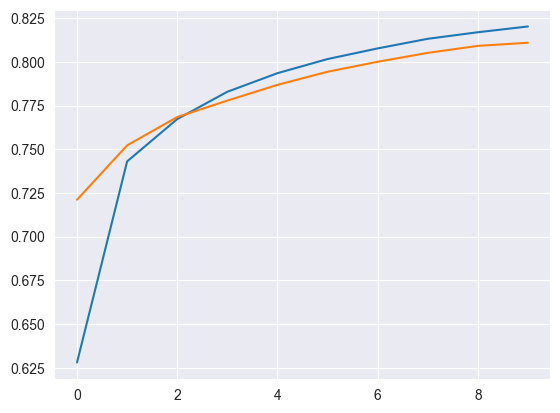

final test_acc=0.810900


In [180]:
epochs = 10
batch = 1024
lr = 0.00001

nn_model = NN(28 * 28, n_class)
nn_model.set_loss(mse, mse_d)
nn_model.learn(x_train, y_train, epochs, batch, lr, x_test, y_test)


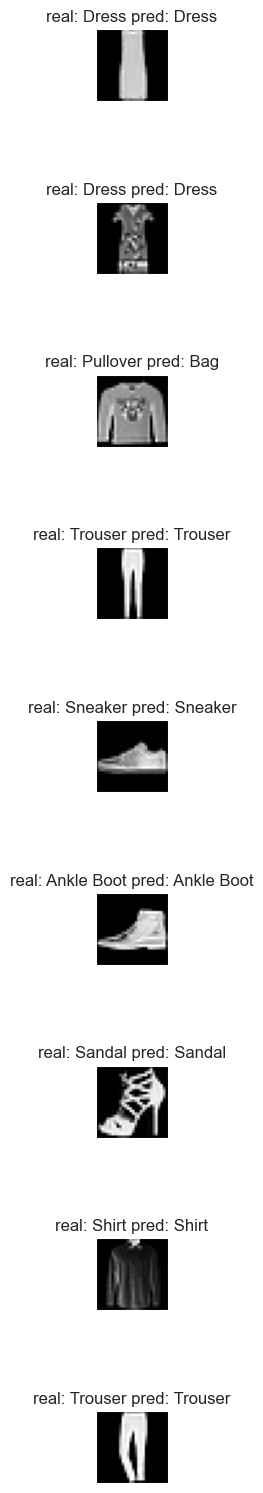

In [193]:
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
fig = plt.figure(figsize=(80, 20), facecolor='w')
for j in range(9):
    rn = np.random.randint(len(x_train))
    x_rn = x_train[rn]
    y_rn = nn_model.predict(x_rn)
    ax = plt.subplot(18, 1, 2*j + 1)
    xi, yi = train_data[rn]
    plt.title("real: " + labels[yi] + " pred: " + labels[y_rn])
    plt.imshow(xi, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('fashionMNIST_samples.png', bbox_inches='tight')
plt.show()